Maham Waseem (27257)

# Importing Necessary Libraries

In [1]:
import numpy as np
import cv2 as cv
from sklearn.cluster import MeanShift
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

# Importing Images Functions

In [2]:
# Function to import the image
def import_image(image_path):
    img = cv.imread(image_path)
    return img


# Removing Noise Function

In [3]:
# Function to filter the image to reduce noise
def filter_noise(img):
    img_filtered = cv.medianBlur(img, 3)
    return img_filtered


# Flatten Image Function

In [4]:
# Function to flatten the image
def flatten_image(img):
    flat_image = img.reshape((-1, 3))
    flat_image = np.float32(flat_image)
    return flat_image

In [4]:
# Function to flatten the image
def flatten_image(img):
    flat_image = img.reshape((-1, 3))
    flat_image = np.float32(flat_image)
    return flat_image

# Number of Samples from Images Function

In [5]:
# Function to calculate the number of samples
def get_num_samples(flat_image):
    num_samples = flat_image.shape[0]
    return num_samples


# Rule of Thumb to know the optimum BandWidth

In [6]:
# Function to calculate bandwidth using Rule of Thumb
def rule_of_thumb_bandwidth(X, k=5):
    nbrs = NearestNeighbors(n_neighbors=k).fit(X)
    distances, _ = nbrs.kneighbors(X)
    kth_distances = distances[:, -1]
    bandwidth = np.median(kth_distances)
    print(f"Estimated Bandwidth (Rule of Thumb): {bandwidth}")
    return bandwidth

# Grid Search Function to know the optimum bandwidth

In [208]:
# Function for grid search to find the best combination of bandwidth and number of samples
def grid_search_mean_shift(flat_image, bandwidth_range, sample_range):
    """
    Perform grid search for MeanShift clustering to find the best combination of bandwidth and number of samples.
    """
    best_sil_score = -1  # Initialize best score
    best_bandwidth = None
    best_sample_size = None
    best_labeled = None
    best_ms = None

    # Iterate over different bandwidth and sample sizes
    for bandwidth in bandwidth_range:
        for sample_size in sample_range:
            print(f"Testing bandwidth={bandwidth}, sample_size={sample_size}")

            # Perform MeanShift clustering
            labeled, ms, sil_score = mean_shift_clustering(flat_image, bandwidth)

            # If the silhouette score is better than the previous best, update the best parameters
            if sil_score > best_sil_score:
                best_sil_score = sil_score
                best_bandwidth = bandwidth
                best_sample_size = sample_size
                best_labeled = labeled
                best_ms = ms

    print(f"Best Bandwidth={best_bandwidth}, Best Sample Size={best_sample_size}, Best Silhouette Score={best_sil_score}")
    return best_bandwidth, best_sample_size, best_labeled, best_ms, best_sil_score

# Meanshift Function

In [7]:
# Function for MeanShift clustering
def mean_shift_clustering(flat_image, bandwidth):
    """
    Perform MeanShift clustering on the flattened image with the specified bandwidth.
    """
    ms = MeanShift(bandwidth=bandwidth, max_iter=800, bin_seeding=True)
    ms.fit(flat_image)

    labeled = ms.labels_
    segments = np.unique(labeled)

    # Calculate silhouette score if more than one cluster exists
    if len(segments) > 1:
        sil_score = silhouette_score(flat_image, labeled)
    else:
        sil_score = -1

    print(f"Bandwidth={bandwidth}, num_segments={segments.shape[0]}, silhouette_score={sil_score}")
    return labeled, ms, sil_score

# Learning the number of Segments

In [8]:

# Function to get the number of segments
def get_number_of_segments(labeled):
    segments = np.unique(labeled)
    print('Number of segments: ', segments.shape[0])
    return segments


# Average color calculation function

In [131]:
# Average color calculation function
def get_average_color(labeled, flat_image):
    """
    Calculate the average color of each segment.

    Parameters:
        labeled (numpy array): Cluster labels for each pixel.
        flat_image (numpy array): Flattened image (n_samples x 3).

    Returns:
        numpy array: Array of average colors for each segment.
    """
    # Get the unique labels and determine the number of segments
    unique_labels = np.unique(labeled)
    num_segments = len(unique_labels)  # This will be the correct number of segments

    total = np.zeros((num_segments, 3), dtype=float)  # Sum of colors for each segment
    count = np.zeros(num_segments, dtype=float)  # Count of pixels per segment

    # Accumulate color values and pixel counts for each segment
    for i, label in enumerate(labeled):
        # Find the index of the label in the unique_labels array
        label_index = np.where(unique_labels == label)[0][0]
        total[label_index] += flat_image[i]
        count[label_index] += 1

    # Avoid division by zero by setting count to 1 for empty segments
    count[count == 0] = 1

    # Calculate average colors for each segment
    avg = total / count[:, None]
    avg = np.uint8(avg)  # Convert to uint8 type
    return avg, unique_labels

# Function to cast the labeled image into the corresponding average color


In [132]:
# Function to cast the labeled image into the corresponding average color
def cast_label_to_color(labeled, avg, unique_labels, img_shape):
    """
    Map the labels of each pixel to the corresponding average color.

    Parameters:
        labeled (numpy array): Cluster labels for each pixel.
        avg (numpy array): Array of average colors for each segment.
        unique_labels (numpy array): Unique labels from the clustering.
        img_shape (tuple): The shape of the original image (height, width, 3).

    Returns:
        numpy array: The segmented image with each pixel mapped to its average color.
    """
    # Map each label in labeled to the corresponding average color
    res = np.zeros((labeled.shape[0], 3), dtype=np.uint8)

    # Loop through each unique label and assign the corresponding average color
    for i, label in enumerate(labeled):
        # Find the index of the label in unique_labels
        label_index = np.where(unique_labels == label)[0][0]
        res[i] = avg[label_index]

    # Reshape the result to the original image shape
    result = res.reshape(img_shape)  # Ensure img_shape corresponds to (height, width, 3)
    return result

# Function to visualize results


In [11]:
# Function to visualize results
def visualize_results(original, result, bandwidth):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(cv.cvtColor(original, cv.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(cv.cvtColor(result, cv.COLOR_BGR2RGB))
    plt.title(f"Segmented Image\nBandwidth={bandwidth}")
    plt.axis('off')

    plt.show()

# Master Function

In [209]:
image_path = '/content/images.jpeg'  # Provide the path to your image here
img = import_image(image_path)
img_filtered = filter_noise(img)


In [210]:
flat_image = flatten_image(img_filtered)


In [211]:
# 3. Get the number of samples
num_samples = get_num_samples(flat_image)
print(f"Number of samples: {num_samples}")


Number of samples: 50382


In [213]:
bandwidth_range = np.arange(2, 80, 40)  # Example range for bandwidth
sample_range = [50382]  # Example range for sample sizes

best_bandwidth, best_sample_size, best_labeled, best_ms, best_sil_score = grid_search_mean_shift(flat_image, bandwidth_range, sample_range)

# The number of clusters (segments) in the best model
num_clusters = len(np.unique(best_labeled))
print(f"Optimal number of clusters: {num_clusters}")

Testing bandwidth=2, sample_size=50382
Bandwidth=2, num_segments=14305, silhouette_score=0.3586841821670532
Testing bandwidth=42, sample_size=50382
Bandwidth=42, num_segments=3, silhouette_score=0.3168381452560425
Best Bandwidth=2, Best Sample Size=50382, Best Silhouette Score=0.3586841821670532
Optimal number of clusters: 14305


In [151]:
    # 4. Calculate bandwidth dynamically
rule_of_thumb_bandwidth(flat_image, k=12)

Estimated Bandwidth (Rule of Thumb): 2.449489742783178


2.449489742783178

# With Optimum Numbers of Clusters

In [152]:
labels, model, silhouette = mean_shift_clustering(flat_image, 2)


Bandwidth=2, num_segments=14305, silhouette_score=0.3586841821670532


In [153]:
segments = get_number_of_segments(labels)


Number of segments:  14305


In [154]:
avg_colors, unique_labels = get_average_color(labels, flat_image)


In [155]:
result = cast_label_to_color(labels, avg_colors, unique_labels, img.shape)


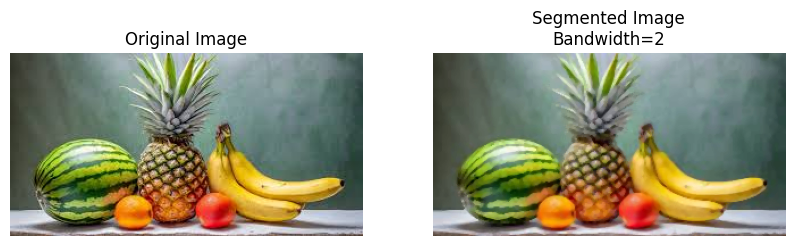

In [156]:
visualize_results(img, result, 2)


Highly Resoluted imaged is observed near to the oringal image

## Increasing Bandwidth Effect

In [157]:
labels, model, silhouette = mean_shift_clustering(flat_image, 80)


Bandwidth=80, num_segments=1, silhouette_score=-1


In [158]:
segments = get_number_of_segments(labels)


Number of segments:  1


In [159]:
avg_colors, unique_labels = get_average_color(labels, flat_image)


In [160]:
result = cast_label_to_color(labels, avg_colors, unique_labels, img.shape)


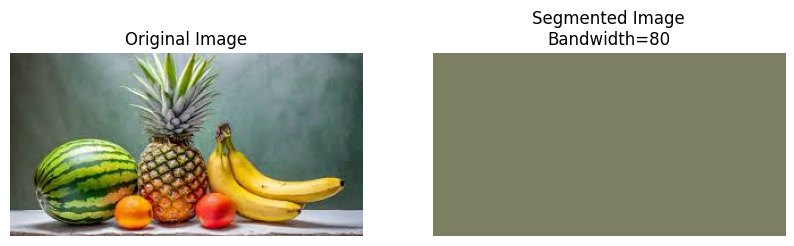

In [161]:
visualize_results(img, result, 80)


## Decreasing bandWidth

In [162]:
labels, model, silhouette = mean_shift_clustering(flat_image, 0.001)


Bandwidth=0.001, num_segments=29545, silhouette_score=0.5510103106498718


In [163]:
segments = get_number_of_segments(labels)


Number of segments:  29545


In [164]:
avg_colors, unique_labels = get_average_color(labels, flat_image)


In [165]:
result = cast_label_to_color(labels, avg_colors, unique_labels, img.shape)


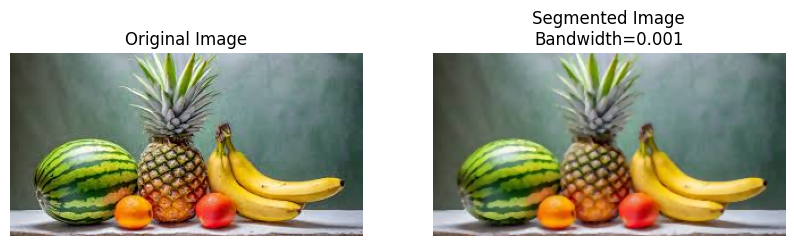

In [166]:
visualize_results(img, result, 0.001)


Resolution increases

# With Different Image

In [214]:
image_path = '/content/91WoERhjv-L.__AC_SY300_SX300_QL70_ML2_.jpg'  # Provide the path to your image here
img = import_image(image_path)
img_filtered = filter_noise(img)


In [215]:
flat_image = flatten_image(img_filtered)


In [216]:
# 3. Get the number of samples
num_samples = get_num_samples(flat_image)
print(f"Number of samples: {num_samples}")


Number of samples: 63600


In [217]:
bandwidth_range = np.arange(2, 80, 40)  # Example range for bandwidth
sample_range = [63600]  # Example range for sample sizes

best_bandwidth, best_sample_size, best_labeled, best_ms, best_sil_score = grid_search_mean_shift(flat_image, bandwidth_range, sample_range)

# The number of clusters (segments) in the best model
num_clusters = len(np.unique(best_labeled))
print(f"Optimal number of clusters: {num_clusters}")

Testing bandwidth=2, sample_size=63600
Bandwidth=2, num_segments=3600, silhouette_score=0.3426925837993622
Testing bandwidth=42, sample_size=63600
Bandwidth=42, num_segments=1, silhouette_score=-1
Best Bandwidth=2, Best Sample Size=63600, Best Silhouette Score=0.3426925837993622
Optimal number of clusters: 3600


In [171]:
    # 4. Calculate bandwidth dynamically
rule_of_thumb_bandwidth(flat_image, k=40)

Estimated Bandwidth (Rule of Thumb): 1.4142135623730951


1.4142135623730951

In [ ]:
#With Optimum Banwidth

In [172]:
labels, model, silhouette = mean_shift_clustering(flat_image, 1.4)


Bandwidth=1.4, num_segments=6872, silhouette_score=0.5033459663391113


In [173]:
segments = get_number_of_segments(labels)


Number of segments:  6872


In [174]:
avg_colors, unique_labels = get_average_color(labels, flat_image)


In [175]:
result = cast_label_to_color(labels, avg_colors, unique_labels, img.shape)


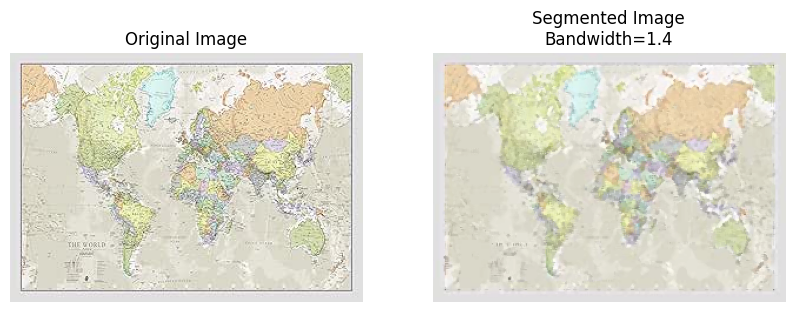

In [177]:
visualize_results(img, result, 1.4)


PRoper clustering of image is done

In [ ]:
#By increasing value

In [178]:
labels, model, silhouette = mean_shift_clustering(flat_image, 40)


Bandwidth=20, num_segments=3, silhouette_score=0.48821723461151123


In [179]:
segments = get_number_of_segments(labels)


Number of segments:  3


In [180]:
avg_colors, unique_labels = get_average_color(labels, flat_image)


In [181]:
result = cast_label_to_color(labels, avg_colors, unique_labels, img.shape)


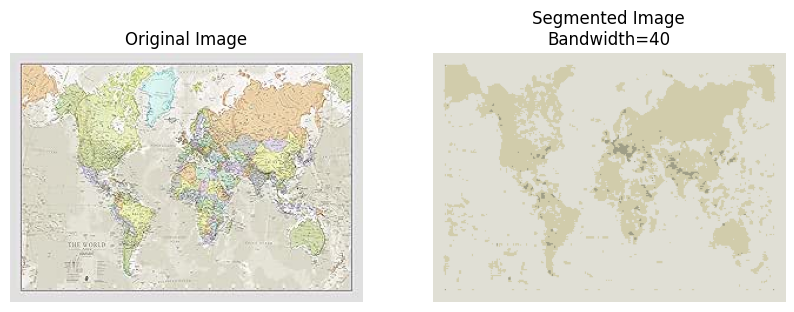

In [182]:
visualize_results(img, result, 40)


By Decreasing Bandwidth

In [183]:
labels, model, silhouette = mean_shift_clustering(flat_image, 0.0001)


Bandwidth=0.0001, num_segments=15523, silhouette_score=0.8710534572601318


In [184]:
segments = get_number_of_segments(labels)


Number of segments:  15523


In [185]:
avg_colors, unique_labels = get_average_color(labels, flat_image)


In [186]:
result = cast_label_to_color(labels, avg_colors, unique_labels, img.shape)


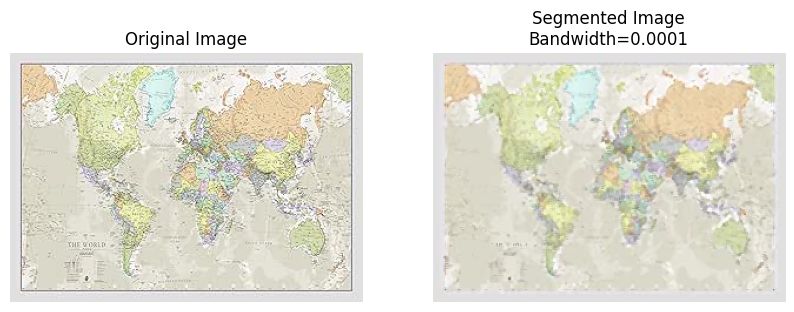

In [187]:
visualize_results(img, result, 0.0001)


Blur Image

With Different Image

In [188]:
image_path = '/content/istockphoto-529664572-612x612.jpg'  # Provide the path to your image here
img = import_image(image_path)
img_filtered = filter_noise(img)

In [189]:
flat_image = flatten_image(img_filtered)


In [190]:
# 3. Get the number of samples
num_samples = get_num_samples(flat_image)
print(f"Number of samples: {num_samples}")


Number of samples: 249696


In [191]:
    # 4. Calculate bandwidth dynamically
rule_of_thumb_bandwidth(flat_image, k=40)

Estimated Bandwidth (Rule of Thumb): 3.7416573867739413


3.7416573867739413

In [ ]:
#With Optimum Bandwidth

In [192]:
labels, model, silhouette = mean_shift_clustering(flat_image, 4)


Bandwidth=4, num_segments=10247, silhouette_score=0.21874476969242096


In [193]:
segments = get_number_of_segments(labels)


Number of segments:  10247


In [194]:
avg_colors, unique_labels = get_average_color(labels, flat_image)


In [195]:
result = cast_label_to_color(labels, avg_colors, unique_labels, img.shape)


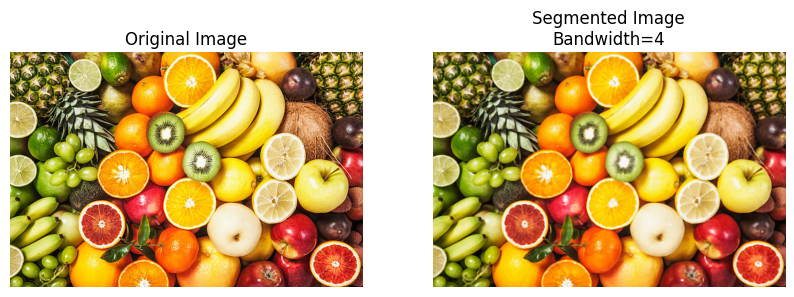

In [197]:
visualize_results(img, result, 4)


# Higly Resoluted Image is created

# By increasing the Bandwidth

In [198]:
labels, model, silhouette = mean_shift_clustering(flat_image, 100)


Bandwidth=100, num_segments=2, silhouette_score=0.48339277505874634


In [199]:
segments = get_number_of_segments(labels)


Number of segments:  2


In [200]:
avg_colors, unique_labels = get_average_color(labels, flat_image)


In [201]:
result = cast_label_to_color(labels, avg_colors, unique_labels, img.shape)


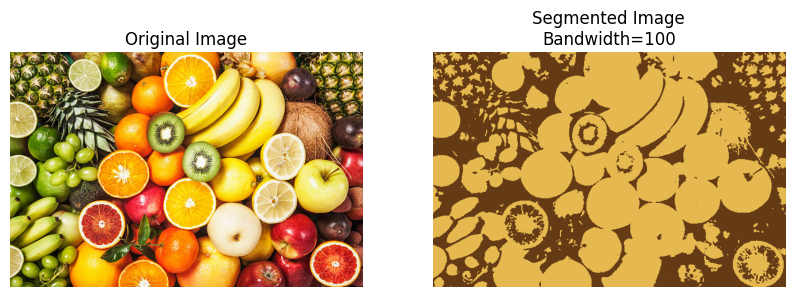

In [202]:
visualize_results(img, result, 100)

By Decreasing the Bandwidth

In [203]:
labels, model, silhouette = mean_shift_clustering(flat_image, 0.0001)


Bandwidth=0.0001, num_segments=182782, silhouette_score=0.41514483094215393


In [204]:
segments = get_number_of_segments(labels)


Number of segments:  182782


In [205]:
avg_colors, unique_labels = get_average_color(labels, flat_image)


In [206]:
result = cast_label_to_color(labels, avg_colors, unique_labels, img.shape)


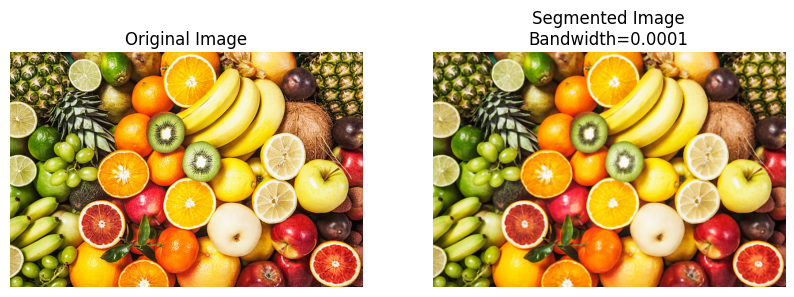

In [207]:
visualize_results(img, result, 0.0001)